# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# YouTube data extraction

At first, I wanted to analyze all PS5 and Xbox tweets in September as many announcements occured that month (price, games, etc.). But it was too difficult for me to get the Twitter data. The API limitations only let me have access to the last 7 days of data. I also had a look at the scrapers (Twint, tweetscraper, GetOldTweets3, etc.) but they were all down for some reasons...
Therefore, I decided to change a bit the scope of the project.

I will have a look at the YouTube comments of both PS5 and Xbox games showcases.
The PS5 showcase occured on the 16th of September while the Xbox Series X showcase occured on the 23rd of July.

In [2]:
Xbox_data = pd.read_fwf('Xbox_comments.txt',header=None)

In [3]:
Xbox_data.fillna('',inplace=True)

In [4]:
#Consolidating text together in one column
Xbox_data['Text'] = Xbox_data[2]
Xbox_data.drop(2,axis=1,inplace=True)
for i in range(3,21):
    Xbox_data['Text']=Xbox_data['Text'] + " " + Xbox_data[i]
    Xbox_data.drop(i,axis=1,inplace=True)

In [5]:
#Removing ":" from end of column "1" (hours)
Xbox_data[1]=Xbox_data[1].apply(lambda x: x[:-1])

In [6]:
#Renaming columns
Xbox_data.rename(columns={0:'Date',1:'Hour'},inplace=True)

In [7]:
Xbox_data.tail()

,Date,Hour,Text
1148,2020-09-27,19:39:25,Pyschonauts looks mad
1149,2020-09-27,19:55:25,Cross fire looks incredible
1150,2020-09-28,10:49:45,What's the song at the end ?
1151,2020-09-29,06:05:50,why are people disliking this?
1152,2020-09-30,16:41:25,Imagine Fallout and Elder Scrolls with these g...


# Text processing

In [8]:
import nltk
import re

In [9]:
#Creating a function to clean the comments
def clean_text(text):
    text = re.sub(r'https?:\/\/\S+', '', text) #Removing hyperlinks
    text = re.sub(r"\d{2}:\d{2}s*", '', text) #Removing timestamps XX:XX
    text = re.sub(r"\d{1}:\d{2}s*", '', text) #Removing timestamps X:XX
    text = re.sub('[^A-Za-z0-9 ]+', '', text) #Removing special characters
    return text

In [10]:
Xbox_data['Text']=Xbox_data['Text'].apply(clean_text)

In [11]:
Xbox_data.head()

,Date,Hour,Text
0,2020-07-23,16:59:51,First
1,2020-07-23,16:59:55,bad
2,2020-07-23,16:59:56,First
3,2020-07-23,16:59:58,First comment
4,2020-07-23,17:00:02,Hello


# Tokenizer / Part-of-Speech tagging / Lemmatizer / Stop words removal

Below, a lot of steps are performed in one-go that I will explain in more details.

My goal is to clean the comments so that words are standardized for the word clouds and sentiment analysis.

- First I tokenize the comments, this means that each word in a sentence is isolated 
          Example: "I ate these fruits." => [I, ate, these, fruits]
- Then, I perform part-of-speech (POS) tagging which goal is to classify isolated words by their type (nouns, verbs...) and add some context to the sentence
          Example: [I, ate, these, fruits] => [('I', 'PRP'), ('ate', 'VBP'), ('these', 'DT'), ('fruits', 'NNS')]
- Then, I lemmatize these words. That means that all words are brought back to their root form. The previous step helps the lemmatizer to perform better.
          Example: [('I', 'PRP'), ('ate', 'VBP'), ('these', 'DT'), ('fruits', 'NNS')] => [I, eat, these, fruit]
- Eventually, I remove all the stop words in order to keep only essential words in the sentence.
          Example: [I, eat, these, fruit] => [eat, fruit]

In [12]:
from nltk.corpus import wordnet
from nltk import pos_tag

def get_wordnet_pos(word):
    #Map POS tag to first character lemmatize() accepts
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [13]:
#We need to install the "stopwords" corpus in order to remove the stopwords
#nltk.download()

In [14]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

lm = WordNetLemmatizer()

Xbox_data['Text clean'] = ""
for i in range(0,len(Xbox_data)):
    Xbox_data['Text clean'].loc[i] = [lm.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(Xbox_data['Text'].loc[i])]
    Xbox_data['Text clean'].loc[i] = [word for word in Xbox_data['Text clean'].loc[i] if word.lower() not in stopwords.words('english')]
    Xbox_data['Text clean'].loc[i] = " ".join(Xbox_data['Text clean'].loc[i])

In [15]:
Xbox_data.head()

,Date,Hour,Text,Text clean
0,2020-07-23,16:59:51,First,First
1,2020-07-23,16:59:55,bad,bad
2,2020-07-23,16:59:56,First,First
3,2020-07-23,16:59:58,First comment,First comment
4,2020-07-23,17:00:02,Hello,Hello


# Word cloud

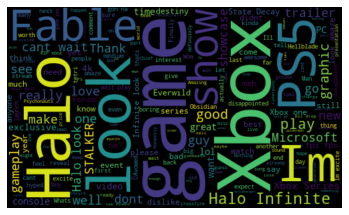

In [16]:
#Creating a word cloud
from wordcloud import WordCloud

full_text = ' '.join([txt for txt in Xbox_data['Text clean']])
wordcloud = WordCloud(width=500, height=300, max_font_size=119).generate(full_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Most discussed games

I need to create a list of the games featured at each showcase. Then isolate these games in the YouTube comments to determine which games were the most discussed by brand.

# Sentiment Analysis